In [1]:
#%% Imports
import os
import numpy as np
import spectral
import matplotlib.pyplot as plt
from skimage import exposure, io

from scipy import stats

# Import "local" packages
import hyspec_io, image_render, preprocess, misc 

In [2]:
import importlib
importlib.reload(preprocess)

<module 'preprocess' from '/home/mha114/Dropbox/Python/massimal/tools/preprocess.py'>

In [3]:
#%% Paths
ex_file = '/media/mha114/Massimal/Larvik_Olberg/Hyperspectral/20210825/OlbergAreaS/Radiance_Georef/OlbergholmenS_Pika_L_17-Radiance From Raw Data-Georectify Airborne Datacube.bip.hdr'
output_dir = '/media/mha114/Massimal/Larvik_Olberg/Hyperspectral/Test_IndBandStretch'

In [4]:
#%% Import data
(im,wl,rgb_ind,metadata) = hyspec_io.load_envi_image(ex_file)

In [13]:
im_rgb = im[:,:,rgb_ind]

In [14]:
#%% Determine suitable limits for each band
zeros_mask = np.all(im_rgb==0,axis=2)

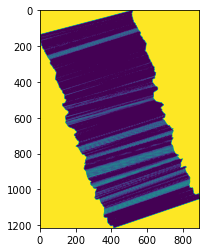

In [15]:
plt.imshow(zeros_mask)

In [16]:
for band_im in np.moveaxis(im_rgb,2,0):
    print(band_im.shape)

(1215, 891)
(1215, 891)
(1215, 891)


In [18]:
rend_lim = [np.percentile(band_im[~zeros_mask],(2,98)) for band_im in np.moveaxis(im_rgb,2,0)]
print(rend_lim)

[array([195., 788.]), array([ 437., 1335.]), array([344., 986.])]


In [41]:
limits = np.asarray(rend_lim)

In [42]:
limits.shape

(3, 2)

In [44]:
limits.size > 2

True

In [50]:
limits[0,1]

788.0

In [ ]:
# Need function for randomly sampling a set of images.

In [20]:
type(rend_lim[0])

numpy.ndarray

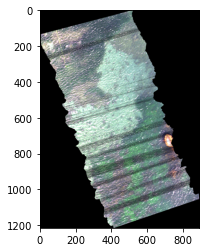

In [21]:
plt.imshow(image_render.percentile_stretch(im_rgb))

In [38]:
def percentile_stretch_x(image,percentiles=(2,98),separate_bands=True, ignore_zeros = True):
    
    # Preallocate output array
    im_rescaled = np.zeros(image.shape)

    # Create mask indicating non-zero pixels
    if ignore_zeros:
        mask = ~np.all(image==0,axis=2)
    else:
        mask = np.ones(image.shape[:-1],dtype=bool)
    
    # Case: Stretch bands separately 
    if separate_bands:
        assert image.ndim == 3      # Assuming 3 dimensions
        # for ii in range(image.shape[2]):
        for ii,image_band in enumerate(np.moveaxis(image,2,0)):
            p_low,p_high = np.percentile(image_band[mask], percentiles)
            im_rescaled[:,:,ii] = exposure.rescale_intensity(image_band, in_range=(p_low,p_high))
    
    # Case: Stretch whole image based on "global" percentiles 
    else:
        p_low,p_high = np.percentile(image[mask], percentiles)
        im_rescaled = exposure.rescale_intensity( image, in_range=(p_low,p_high))

    return im_rescaled

195.0
788.0
437.0
1335.0
344.0
986.0


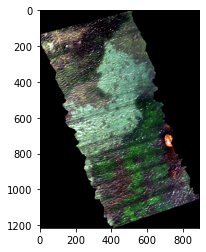

In [39]:
plt.imshow(percentile_stretch_x(im_rgb))

In [51]:
def absolute_stretch(image,limits):
    """ Image stretch based on absolute limits (not data-dependent)

    # Usage:
    im_rescaled = absolute_stretch(image,limits,...)

    # Required arguments:
    image:          2D or 3D numpy array, image bands stacked along 3rd
                    dimension
    limits:         Numpy array indicating upper and lower limits
                    To apply a "global" stretch (same limits for each band),
                    limits should be a 2-element array: [low,high]
                    To apply a individual stretch to each band,
                    limits should be a [N_bands,2] size array

    # Optional arguments:
    ignore_zeros:   Default: True
                    If true, the calculation of percentiles does not include
                    pixels that are equal to zero in every band.

    Returns:
        im_rescaled:    Image linearly "stretched" between percentile values.

    The function uses skimage.exposure.rescale_intensity() for rescaling.
    See https://scikit-image.org/docs/stable/api/skimage.exposure.html
    """
    
    # Preallocate output array
    im_rescaled = np.zeros(image.shape)

    # Case: Stretch bands separately 
    if limits.size > 2:
        assert image.ndim == 3      # Assuming 3 dimensions
        assert limits.shape[0] == image.shape[2]

        for ii,image_band in enumerate(np.moveaxis(image,2,0)):
            im_rescaled[:,:,ii] = exposure.rescale_intensity(image_band, in_range=(limits[ii,0],limits[ii,1]))
    
    # Case: Stretch whole image based on "global" limits
    else:
        im_rescaled = exposure.rescale_intensity(image, in_range=(limits[0],limits[1]))

    return im_rescaled

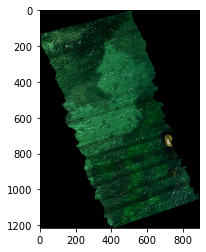

In [54]:
plt.imshow(absolute_stretch(im_rgb,np.array([300,2000])))

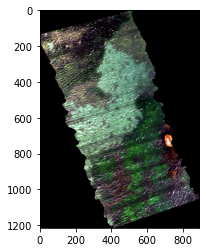

In [55]:
limits = np.array([[200,800],[450,1350],[350,1000]])
plt.imshow(absolute_stretch(im_rgb,limits))

In [56]:
limits

array([[ 200,  800],
       [ 450, 1350],
       [ 350, 1000]])

In [57]:
# Try selecting a randum percentage of the image
X = im[~zeros_mask]

In [59]:
X.shape

(543307, 300)

In [58]:
from numpy.random import default_rng
rng = default_rng()

In [66]:
frac = 0.05
n_samp = np.int32(frac*X.shape[0])
X_random_samp = rng.choice(X,size=n_samp,axis=0,replace=False)

In [68]:
X_random_samp.shape

(27165, 300)

In [69]:
mask_alltrue = np.ones(im.shape[:-1],dtype=bool)
X2 = im[mask_alltrue]

In [70]:
X2.shape

(1082565, 300)

In [74]:
def random_sample_image(image,frac=0.05,ignore_zeros=True,replace=False):
    """ Draw random samples from image

    # Usage:
    samp = random_sample_image(image,...)

    # Required arguments:
    image:  3D numpy array with hyperspectral image, wavelengths along
            third axis (axis=2)

    # Optional arguments:
    frac:           Number of samples expressed as a fraction of the total
                    number of samples in the image. Range: [0 - 1]
    ignore_zeros:   Do not include samples that are equal to zeros across all
                    bands.
    replacement:    Whether to select samples with or without replacement.

    # returns
    samp:   2D numpy array of size NxB, with N denoting number of samples and B
            denoting number of bands.
    """

    # Create mask
    if ignore_zeros:
        mask = ~np.all(image==0,axis=2)
    else:
        mask = np.ones(image.shape[:-1],axis=2)

    # Calculate number of samples
    n_samp = np.int64(frac*X.shape[0])

    # Create random number generator
    rng = default_rng()
    samp = rng.choice(image[mask],size=n_samp,axis=0,replace=replace)
    
    return samp

In [78]:
samp = random_sample_image(im,replace=True)

In [79]:
samp.shape

(27165, 300)

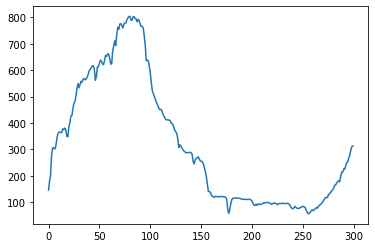

In [77]:
plt.plot(samp.mean(axis=0))

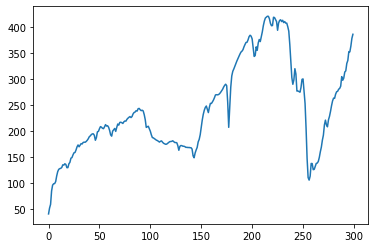

In [80]:
plt.plot(samp.std(axis=0))